In [1]:
# utils
%load_ext autoreload
%autoreload 1

import sys
import os
sys.path.append("../utils/")
%aimport utils

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import MulticoreTSNE as mcTSNE

Using TensorFlow backend.


In [2]:
tcga, tcga_idx_to_sample, \
tcga_idx_to_gene, \
tcga_clinical, \
tcga_sample_types = utils.load_PANCAN_TCGA_from_matrix()

In [3]:
tcga_sample_to_idx = pd.Series(index = tcga_idx_to_sample.values, data = tcga_idx_to_sample.index)

<Figure size 432x288 with 0 Axes>

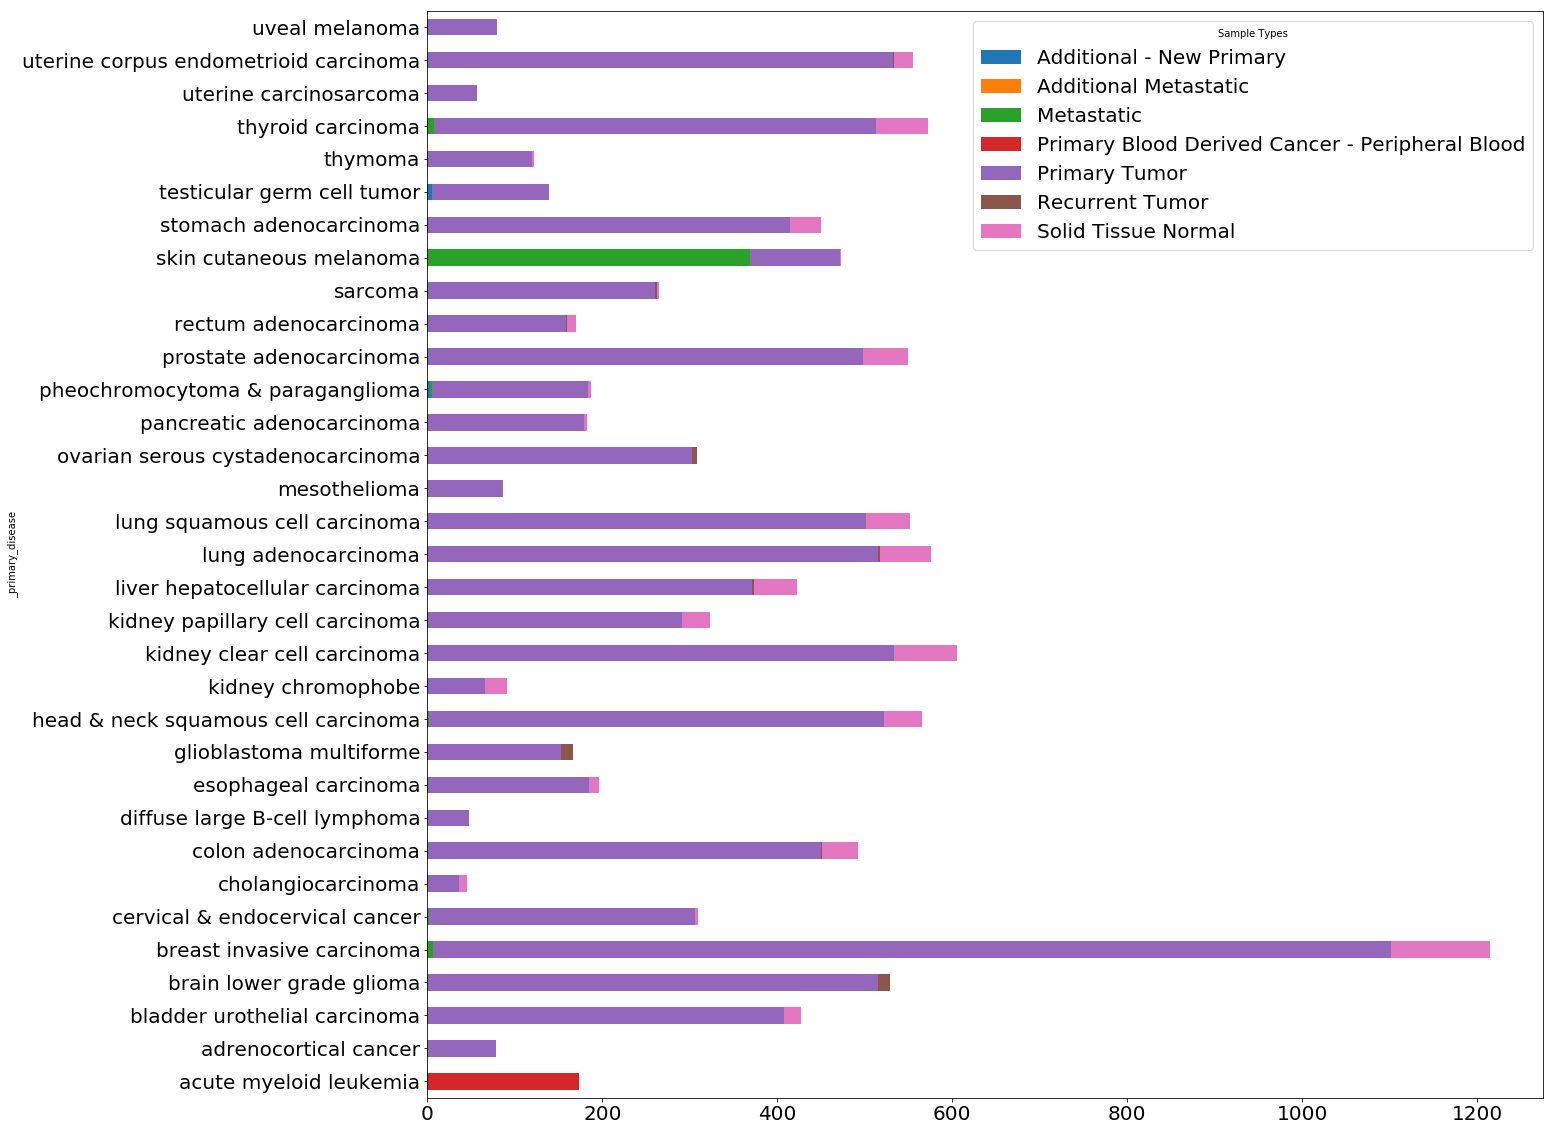

In [4]:
plt.figure()
tcga_sample_types.groupby(['_primary_disease', 'sample_type']).size().reset_index()\
    .pivot(columns="sample_type", index="_primary_disease", values=0).fillna(0).astype(int)\
    .plot.barh(stacked=True, figsize=(20,20), fontsize=20)
plt.legend(title="Sample Types", fontsize=20)
plt.show()

In [5]:
AJCC_STAGING = 'ajcc_pathologic_tumor_stage'
CLINICAL_STAGING = 'clinical_stage'
HISTOLOGICAL_GRADE = 'histological_grade'
CANCER_TYPE = 'cancer type abbreviation'

In [6]:
# UNKNOWNS = []

# path_stage_to_name = {
#     -1:['UNKNOWN'],
#     1: ['Stage I', 'Stage IA', 'Stage IB'],
#     2: ['Stage II','Stage IIA','Stage IIB'],
#     3: ['Stage III','Stage IIIA','Stage IIIB','Stage IIIC'],
#     4: ['Stage IV']
# }

# name_to_path_stage = {k:v for v in path_stage_to_name.keys() for k in path_stage_to_name[v]}
    
# selected_tumor_type = 'BRCA'

# selected_tumor = tcga_clinical.loc[ tcga_clinical[CANCER_TYPE] == selected_tumor_type, 
#                                    [CANCER_TYPE, AJCC_STAGING]]\
#                     .replace(to_replace=[np.nan, '[Discrepancy]', 'Stage X'], value="UNKNOWN")\
#                     .assign(stage = lambda x: x[AJCC_STAGING].map(lambda y: name_to_path_stage[y]))

# stage_order = sorted(selected_tumor[AJCC_STAGING].unique())

# plt.figure(figsize=(10, 15))
# plt.subplot(2, 1, 1)
# sns.countplot(selected_tumor.loc[selected_tumor.stage >= 0, 'stage'])
# plt.title(selected_tumor_type)

# plt.subplot(2, 1, 2)
# sns.countplot(selected_tumor.loc[selected_tumor.stage >= 0, AJCC_STAGING], order=stage_order[:-1])
# plt.title(selected_tumor_type)
# plt.xticks(rotation=90)

# plt.tight_layout()
# plt.show()

In [7]:
grade_name_homogeneous = {
    np.nan: (np.nan, np.nan),
    '[Unknown]': (np.nan, np.nan),
    '[Discrepancy]': (np.nan, np.nan),
    'GB': ('Border Line', 0),
    'GX': (np.nan, np.nan),
    'G1': ('Low Grade', 1),
    'G2': ('Low Grade', 2),
    'G3': ('High Grade', 3),
    'G4': ('High Grade', 4),
    'High Grade': ('High Grade', np.nan),
    'Low Grade': ('Low Grade', np.nan)
}

def transform_grade(x):
    grade = x[HISTOLOGICAL_GRADE]
    high_level, grade_number = grade_name_homogeneous[grade]
    x['HIGH_LEVEL_GRADE'] = high_level
    x['GRADE'] = grade_number
    return x

In [8]:
stage_name_homogeneous = {
    
    np.nan:          (np.nan, np.nan, np.nan),      # UNKNOWN
    '[Discrepancy]': (np.nan, np.nan, np.nan),      # UNKNOWN
    'Stage X':       (np.nan, np.nan, np.nan),      # UNKNOWN
    '[Unknown]':     (np.nan, np.nan, np.nan),      # UNKNOWN
    
    'Stage 0': (0,np.nan, np.nan),   # in-situ
    'IS':      (0,np.nan, np.nan),   # in-situ
    'Stage IS':(0,np.nan, np.nan),   # in-situ
    
    'Stage I': (1,np.nan, np.nan),   # Stage 1
    'I':       (1,np.nan, np.nan),   # Stage 1
    'Stage IA': (1, "A", np.nan),    # Stage 1
    'Stage IA1':(1, "A", 1),         # Stage 1
    'Stage IA2':(1, "A", 2),         # Stage 1
    'Stage IB': (1, "B", np.nan),    # Stage 1
    'Stage IB1':(1, "B", 1),         # Stage 1
    'Stage IB2':(1, "B", 2),         # Stage 1
    'Stage IC': (1, "C", np.nan),    # Stage 1
    
    'Stage II': (2, np.nan, np.nan), # Stage 2
    'I/II NOS': (2, np.nan, np.nan), # Stage 2
    'Stage IIA':(2, "A", np.nan),    # Stage 2
    'IIa':      (2, "A", np.nan),    # Stage 2
    'Stage IIA1':(2, "A", 1),        # Stage 2
    'Stage IIA2':(2, "A", 2),        # Stage 2
    'Stage IIB':(2, "B", np.nan),    # Stage 2
    'IIb':      (2, "B", np.nan),    # Stage 2
    'Stage IIC':(2, "C", np.nan),    # Stage 2
    
    'Stage III':(3, np.nan, np.nan), # Stage 3
    'III':      (3, np.nan, np.nan), # Stage 3
    'Stage IIIA':(3, "A", np.nan),   # Stage 3
    'Stage IIIB':(3, "B", np.nan),   # Stage 3
    'Stage IIIC':(3, "C", np.nan),   # Stage 3
    'Stage IIIC1':(3, "C", 1),       # Stage 3
    'Stage IIIC2':(3, "C", 2),       # Stage 3
    
    'Stage IV':(4, np.nan, np.nan),  # Stage 4
    'Stage IVA':(4, "A", np.nan),    # Stage 4
    'IVa':      (4, "A", np.nan),    # Stage 4
    'Stage IVB':(4, "B", np.nan),    # Stage 4
    'IVb':      (4, "B", np.nan),    # Stage 4,
    'Stage IVC':(4, "C", np.nan),    # Stage 4
}

def transform_stage(x):
    ajcc = x[AJCC_STAGING]
    clin = x[CLINICAL_STAGING]
    
    ajcc_stage, ajcc_sub_stage, ajcc_sub_sub_stage = stage_name_homogeneous[ajcc]
    x['AJCC_STAGE'] = ajcc_stage
    x['AJCC_STAGE_TYPE'] = ajcc_sub_stage
    x['AJCC_STAGE_SUB_TYPE'] = ajcc_sub_sub_stage
    
    clin_stage, clin_sub_stage, clin_sub_sub_stage = stage_name_homogeneous[clin]
    x['CLINICAL_STAGE'] = clin_stage
    x['CLINICAL_STAGE_TYPE'] = clin_sub_stage
    x['CLINICAL_STAGE_SUB_TYPE'] = clin_sub_sub_stage
    
    return x

In [9]:
tcga_stage_data = tcga_clinical[[CANCER_TYPE, AJCC_STAGING, CLINICAL_STAGING]]\
                    .apply(transform_stage, axis=1)
tcga_grade_data = tcga_clinical[[CANCER_TYPE, HISTOLOGICAL_GRADE]]\
                    .apply(transform_grade, axis=1)

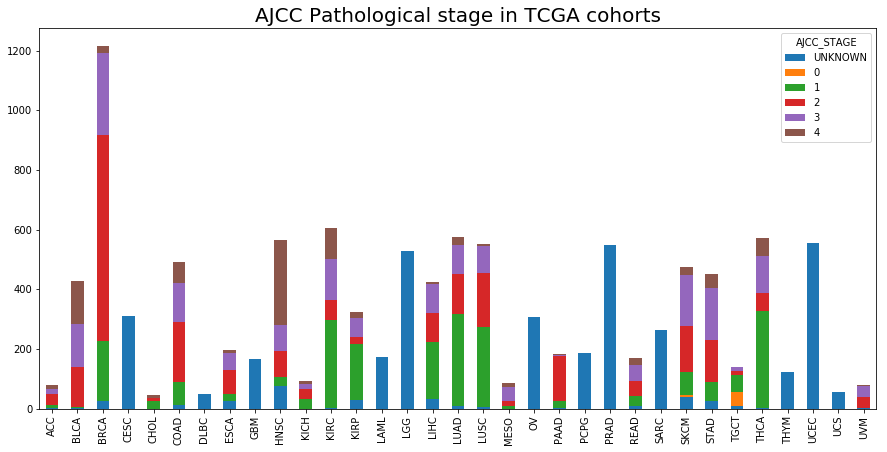

In [10]:
tcga_stage_data\
    .assign(AJCC_STAGE=lambda x: x['AJCC_STAGE'].map(lambda y: y if ~np.isnan(y) else -1).astype(int))\
    .groupby([CANCER_TYPE, 'AJCC_STAGE']).size().reset_index()\
    .pivot(columns="AJCC_STAGE", index=CANCER_TYPE, values=0)\
    .rename(columns={-1: 'UNKNOWN'})\
    .plot.bar(stacked=True, figsize=(15, 7))
plt.title("AJCC Pathological stage in TCGA cohorts", fontsize=20)
plt.xlabel("")
plt.show()

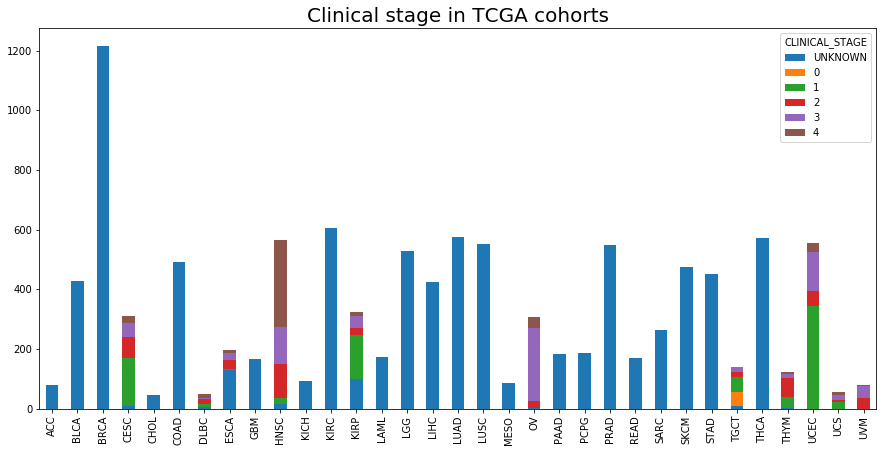

In [11]:
tcga_stage_data\
    .assign(CLINICAL_STAGE=lambda x: x['CLINICAL_STAGE'].map(lambda y: y if ~np.isnan(y) else -1).astype(int))\
    .groupby([CANCER_TYPE, 'CLINICAL_STAGE']).size().reset_index()\
    .pivot(columns="CLINICAL_STAGE", index=CANCER_TYPE, values=0)\
    .rename(columns={-1: 'UNKNOWN'})\
    .plot.bar(stacked=True, figsize=(15, 7))
plt.title("Clinical stage in TCGA cohorts", fontsize=20)
plt.xlabel("")
plt.show()

In [ ]:
tcga_stage_data.to_csv("./results/tcga_stage_data.tsv", sep="\t", index=True, header=True)

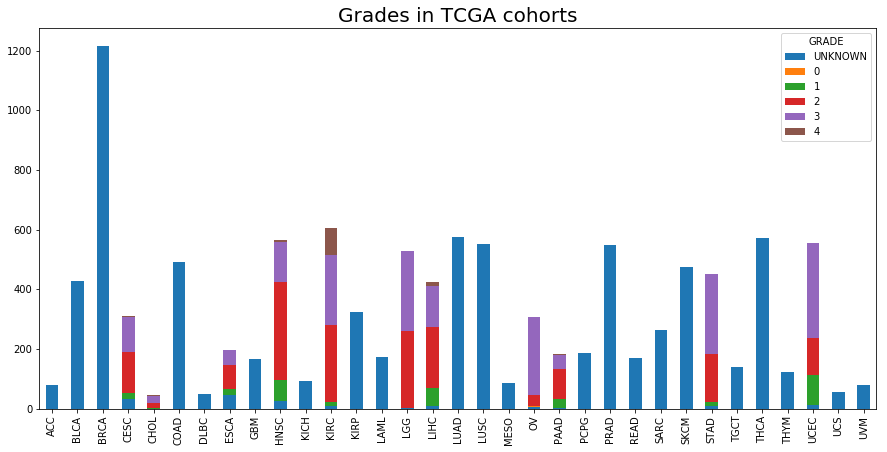

In [12]:
tcga_grade_data\
    .assign(GRADE=lambda x: x['GRADE'].map(lambda y: y if ~np.isnan(y) else -1).astype(int))\
    .groupby([CANCER_TYPE, 'GRADE']).size().reset_index()\
    .pivot(columns="GRADE", index=CANCER_TYPE, values=0)\
    .rename(columns={-1: 'UNKNOWN'})\
    .plot.bar(stacked=True, figsize=(15, 7))
plt.title("Grades in TCGA cohorts", fontsize=20)
plt.xlabel("")
plt.show()

In [ ]:
tcga_grade_data.to_csv("./results/tcga_grade_data.tsv", sep="\t", index=True, header=True)

### Get samples with stage information

In [41]:
samples_with_stage = tcga_stage_data.loc[tcga_stage_data.AJCC_STAGE.notna(), ['cancer type abbreviation', 'AJCC_STAGE']]\
                                    .sort_index()\
                                    .assign(AJCC_STAGE=lambda x: x.AJCC_STAGE.astype(int))

In [42]:
samples_with_stage_idxs = tcga_sample_to_idx[samples_with_stage.index].values

In [43]:
tcga_with_stage = tcga[samples_with_stage_idxs, :]

In [46]:
tcga_with_stage_df = pd.DataFrame(data = tcga_with_stage, index = samples_with_stage.index.tolist(), 
                                  columns=tcga_idx_to_gene.tolist())
tcga_with_stage_df = samples_with_stage.merge(tcga_with_stage_df, left_index = True, right_index = True)\
                                       .rename(columns={'cancer type abbreviation': 'tumor_type'})
tcga_with_stage_df.head()

,tumor_type,AJCC_STAGE,100130426,100133144,100134869,10357,10431,136542,155060,26823,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
TCGA-05-4244-01,LUAD,4,0.0,3.46,3.62,5.66,9.73,0.0,8.44,1.03,...,5.35,8.20,9.91,0.76,10.09,11.47,9.77,9.17,2.93,0.0
TCGA-05-4249-01,LUAD,1,0.0,3.03,3.75,6.52,9.85,0.0,7.19,1.38,...,5.98,8.95,10.20,4.41,9.62,11.20,10.15,9.43,7.50,0.0
TCGA-05-4250-01,LUAD,3,0.0,3.04,2.81,5.66,10.16,0.0,5.72,0.00,...,5.93,8.52,9.72,4.78,8.90,12.41,10.19,9.06,2.87,0.0
TCGA-05-4382-01,LUAD,1,0.0,3.62,3.10,6.39,9.66,0.0,7.91,0.56,...,5.37,8.44,9.89,6.04,9.83,12.73,10.19,9.38,5.18,0.0
TCGA-05-4384-01,LUAD,3,0.0,2.08,2.17,6.20,9.14,0.0,8.10,0.69,...,6.34,9.14,10.37,3.16,9.61,11.71,10.76,9.50,8.57,0.0


In [48]:
tcga_with_stage_df.to_csv("./data/PANCAN_preprocessed/TCGA_with_stage.tsv", sep="\t", index=True, header=True)

## Dimensionality reduction

In [ ]:
selected_tumor = 'BRCA'
sample_to_stage = tcga_stage_data.loc[tcga_stage_data['cancer type abbreviation'] == selected_tumor, "AJCC_STAGE"]\
                        .dropna().astype(int).sort_index()
sample_to_stage.head()

In [ ]:
sel_idx_to_stage = tcga_sample_to_idx.to_frame("idx")\
                                     .merge(sample_to_stage.to_frame("stage"), 
                                            left_index=True, right_index=True)\
                                     .set_index("idx").sort_index()
X_sel = tcga[sel_idx_to_stage.index.tolist(),:]
y_sel = sel_idx_to_stage['stage'].values

In [ ]:
def create_colorMap(y_sel):
    

In [ ]:


tsne = mcTSNE.MulticoreTSNE(n_components=2)
